In [1]:
import numpy as np

import pennylane as qml

from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'numpy'

In [3]:
dev = qml.device("default.qubit", wires=1)

In [4]:
def plot_bloch_sphere():
    # plot the path on Bloch sphere!
    u = np.linspace(0, np.pi, 31)
    v = np.linspace(0, 2 * np.pi, 30)

    bloch_x = np.outer(np.sin(u), np.sin(v))
    bloch_y = np.outer(np.sin(u), np.cos(v))
    bloch_z = np.outer(np.cos(u), np.ones_like(v))

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.plot_wireframe(bloch_x, bloch_y, bloch_z, color='k',alpha=0.1)
    ax.plot(np.cos(v), np.sin(v), 0, color='k', alpha=0.2)
    ax.set_box_aspect([1,1,1])
    ax.azim += 90
    plt.axis('off')

    # Make a 3D quiver plot
    x, y, z = np.zeros((3,3))
    u, v, w = np.array([[1.3,0,0],[0,1.3,0],[0,0,1.3]])

    ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color='k')

    plt.tight_layout(pad=0.1)

    return ax

In [5]:
""" First we show an more explicit example of tomography for Rx rotation gate.
"""

@qml.qnode(dev)
def Rx_test(initial, theta, basis):

    # creates the initial state
    qml.RY(initial[0], wires=0)
    qml.RZ(initial[1], wires=0)

    # rotates around Y axis
    qml.RY(theta, wires=0)

    # changes basis for measurement
    if basis == "X":
        qml.Hadamard(wires=0)
    if basis == "Y":
        qml.S(wires=0)**(-1)
        qml.Hadamard(wires=0)

    return qml.probs(wires=[0])

In [6]:
initial = [0.3*np.pi,0]  # initial 3D Bloch vector

theta_list = [0.05*x for x in range(30)]  # a range of angles to rotate by

# computing the three expectation values, iterating over the angles
psi_x, psi_y, psi_z = [], [], []
for theta in theta_list:
    x_probs = Rx_test(initial, theta, basis="X")
    psi_x.append(x_probs[0] - x_probs[1])

    y_probs = Rx_test(initial, theta, basis="Y")
    psi_y.append(y_probs[0] - y_probs[1])

    z_probs = Rx_test(initial, theta, basis="Z")
    psi_z.append(z_probs[0] - z_probs[1])

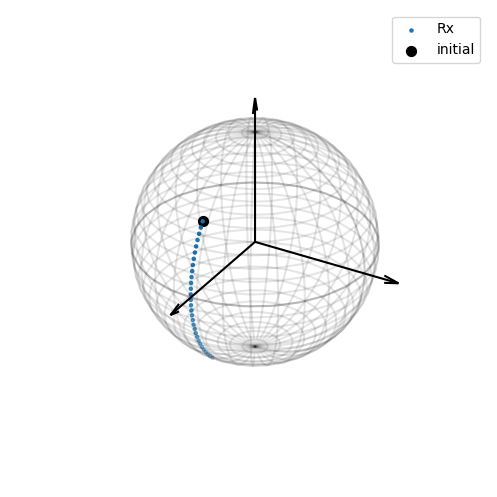

In [7]:
# Plotting the rotations on the Bloch sphere

ax = plot_bloch_sphere()

ax.scatter(psi_x, psi_y, psi_z, marker='.', c="C0", label="Rx")  # rotated Bloch vectors
ax.scatter(psi_x[0], psi_y[0], psi_z[0], marker='o', s=50, c="k", label="initial")  # initial Bloch vector

plt.legend()
plt.show()

In [8]:
""" We now write the circuits in a slightly simpler way.
This will allow us to run the circuit for many angles at once rather than looping over them.
""" 

@qml.qnode(dev)
def Rx_circuit(initial,theta):

    # creates the initial state
    qml.RY(initial[0], wires=0)
    qml.RZ(initial[1], wires=0)

    # rotates around X axis
    qml.RX(theta, wires=0)

    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def Ry_circuit(initial,theta):

    # creates the initial state
    qml.RY(initial[0], wires=0)
    qml.RZ(initial[1], wires=0)

    # rotates around Y axis
    qml.RY(theta, wires=0)

    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def Rz_circuit(initial,theta):

    # creates the initial state
    qml.RY(initial[0], wires=0)
    qml.RZ(initial[1], wires=0)

    # rotates around Z axis
    qml.RZ(theta, wires=0)

    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))

In [9]:
# Rx test to see format of results

initial = [0.3*np.pi,0]

theta = np.array([0.05*x for x in range(30)])

psi_x = Rx_circuit(initial, theta)  # input all angles at once.
print(psi_x)  # return a list of lists, corresponding to the X, Y, Z expectation values

(array([0.80901699, 0.80901699, 0.80901699, 0.80901699, 0.80901699,
       0.80901699, 0.80901699, 0.80901699, 0.80901699, 0.80901699,
       0.80901699, 0.80901699, 0.80901699, 0.80901699, 0.80901699,
       0.80901699, 0.80901699, 0.80901699, 0.80901699, 0.80901699,
       0.80901699, 0.80901699, 0.80901699, 0.80901699, 0.80901699,
       0.80901699, 0.80901699, 0.80901699, 0.80901699, 0.80901699]), array([ 0.        , -0.02937702, -0.05868061, -0.08783753, -0.1167749 ,
       -0.1454204 , -0.17370242, -0.20155027, -0.22889436, -0.25566633,
       -0.28179926, -0.30722784, -0.33188852, -0.35571964, -0.37866166,
       -0.40065721, -0.42165133, -0.44159154, -0.46042801, -0.47811364,
       -0.49460424, -0.50985858, -0.52383854, -0.53650918, -0.54783883,
       -0.55779916, -0.56636529, -0.5735158 , -0.57923282, -0.58350206]), array([0.58778525, 0.58705067, 0.58484877, 0.58118506, 0.57606868,
       0.56951243, 0.5615327 , 0.55214943, 0.54138607, 0.52926953,
       0.51583009, 0.501101

In [10]:
initial = [0.3*np.pi,0]

theta = np.array([0.05*x for x in range(30)])

# run the three rotations gates
psi_x = Rx_circuit(initial, theta)
psi_y = Ry_circuit(initial, theta)
psi_z = Rz_circuit(initial, theta)

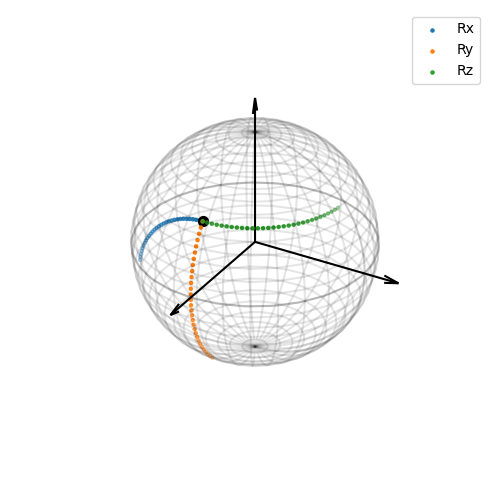

In [11]:
ax = plot_bloch_sphere()

ax.scatter(psi_x[0], psi_x[1], psi_x[2], marker='.', c="C0", label="Rx")
ax.scatter(psi_y[0], psi_y[1], psi_y[2], marker='.', c="C1", label="Ry")
ax.scatter(psi_z[0], psi_z[1], psi_z[2], marker='.', c="C2", label="Rz")
ax.scatter(psi_z[0][0], psi_z[1][0], psi_z[2][0], marker='o', s=50, c="k")

plt.legend()

#plt.savefig("BlochSphere Rotations.pdf", format="pdf", bbox_inches="tight")  # save pdf of figure to file
plt.show()